# Evaluating Models

This notebook is designed to read in and evaluate the performance of our model. Everything should run (hopefully) if you follow these instructions:

1) Download the models from the shared Google Drive (I've uploaded them) and make sure you have the data saved as well (you should have this from last time).
2) Make sure the model files are located in the right place, I recommend having it under `ml4ms_bandgap_final/models/`.
3) Get and configure the correct data and model path. This can be done by right-clicking on your file/directory and selecting "copy path". Or this can be done by opening a terminal (any terminal will do) and `cd` into the `ml4ms_bandgap_final` directory. then `cd` into where ever you have the data `cd data` and type `pwd`. This should print the path to your data. Following the same logic, you can do the same to get the path to your models (`cd models` etc...)
4) Once you have those paths, you'll need to update the corresponding paths below. This may take some effort but read the error messages. They will tell you where things are failing.
5) If everything works okay, you should be able to hit "Run All" at the top, and evaluation metrics will be output for each model.

Look at the outputs and try to understand them. This info is important and tells us how our model performed. This info will be in the report too. If you are unsure what some of the metrics mean (f1 score, recall, etc) look it up, they typically are pretty simple! Hopefully this help! lmk if you have questions!

In [11]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error, classification_report

from tensorflow.keras.metrics import AUC, Precision, Recall, MeanAbsoluteError
import gzip
import pickle
import absl.logging
import logging
from pathlib import Path


In [15]:
# Resolve relative path to the data file
data_path = Path.cwd().parent / "data" / "soap_and_atomic_features.pkl.gz"

# Step 1: Read the compressed pickle
with gzip.open(data_path, 'rb') as f:
    data_df = pickle.load(f)

data_df = data_df.dropna()
print(data_df.shape)
data_df.head()

(5352, 25)


,formula,mpid,gap opt,padded_soap,soap_flat,electronegativity_mean,electronegativity_max,electronegativity_min,electronegativity_std,atomic_radius_mean,...,ionenergies_min,ionenergies_std,covalent_radius_mean,covalent_radius_max,covalent_radius_min,covalent_radius_std,nvalence_mean,nvalence_max,nvalence_min,nvalence_std
0,MgAlPO5,mp-6596,5.2711,"[[7.834700877986906e-05, -0.000248821014237357...","[7.834700877986906e-05, -0.0002488210142373574...",2.78875,3.44,1.31,0.815824,84.375,...,5.985769,2.902622,86.375000,139,63,28.752174,5.000000,6,2,1.581139
1,KBePO4,mp-7324,5.6141,"[[1.224395792223083e-07, -5.548160208843811e-0...","[1.224395792223083e-07, -5.548160208843811e-07...",2.62000,3.44,0.82,0.960065,95.000,...,4.340664,3.337988,94.428571,196,63,48.512885,4.571429,6,1,2.061553
2,As,mp-158,0.0221,"[[0.18087236729129627, 0.4693173276837286, 0.5...","[0.18087236729129627, 0.4693173276837286, 0.55...",2.18000,2.18,2.18,0.000000,115.000,...,9.788550,0.000000,121.000000,121,121,0.000000,5.000000,5,5,0.000000
3,CuHOF,mp-24242,0.0038,"[[8.408499979827601e-07, -6.4356783799753e-06,...","[8.408499979827601e-07, -6.4356783799753e-06, ...",2.88000,3.98,1.90,0.858254,67.500,...,7.726380,3.466954,67.750000,112,32,28.603977,6.250000,11,1,3.561952
4,AgI,mp-567809,1.2599,"[[0.18083827914220227, 0.4690888310062766, 0.5...","[0.18083827914220227, 0.4690888310062766, 0.54...",2.29500,2.66,1.93,0.365000,150.000,...,7.576234,1.437501,130.500000,133,128,2.500000,9.000000,11,7,2.000000


In [3]:
X_atomic_8 = data_df[[
    'electronegativity_mean', 'electronegativity_std', 
    'atomic_radius_mean', 'atomic_radius_std',
    'ionenergies_mean', 'ionenergies_std', 
    'covalent_radius_mean', 'covalent_radius_std',
]]
soaps = np.array(data_df['padded_soap'].tolist())
X_soap_2d = soaps[..., np.newaxis]  # add channel dim: (N, 64, 800, 1)
X_atomic_8 = X_atomic_8.to_numpy()
print('X_soap_2d shape:', X_soap_2d.shape)
print('X_atomic_8 shape:', X_atomic_8.shape)
print('--------------------')

# Step 2: Split the data into training and testing sets
X_soap_train, X_soap_test, X_atomic_8_train, X_atomic_8_test, y_train, y_test = train_test_split(
    X_soap_2d, X_atomic_8, data_df['gap opt'], test_size=0.2, random_state=42
)

bg_threshold = 0.02 # eV
y_train_binary = (y_train > bg_threshold).astype(int)
y_test_binary = (y_test > bg_threshold).astype(int)

# Flatten the soap descriptors for scaling
X_soap_train_flat = X_soap_train.reshape(X_soap_train.shape[0], -1)
X_soap_test_flat = X_soap_test.reshape(X_soap_test.shape[0], -1)

# scale soap descriptors
scaler_soap = MinMaxScaler()

# Fit and transform the training set, and transform the test set
X_soap_train_scaled = scaler_soap.fit_transform(X_soap_train_flat)
X_soap_test_scaled = scaler_soap.transform(X_soap_test_flat)

# Reshape back to the original shape (N, 64, 800, 1)
X_soap_train_scaled = X_soap_train_scaled.reshape(X_soap_train.shape)
X_soap_test_scaled = X_soap_test_scaled.reshape(X_soap_test.shape)

# scale atomic input data
scaler_atomic_8 = MinMaxScaler()

X_atomic_8_train_scaled = scaler_atomic_8.fit_transform(X_atomic_8_train)
X_atomic_8_test_scaled = scaler_atomic_8.transform(X_atomic_8_test)

print('X_soap_train_scaled shape:', X_soap_train_scaled.shape)
print('X_soap_test_scaled shape:', X_soap_test_scaled.shape)
print('X_atomic_8_train_scaled shape:', X_atomic_8_train_scaled.shape)
print('X_atomic_8_test_scaled shape:', X_atomic_8_test_scaled.shape)
print('--------------------')
print('y_train_binary shape:', y_train_binary.shape)
print('y_test_binary shape:', y_test_binary.shape)

X_soap_2d shape: (5352, 64, 800, 1)
X_atomic_8 shape: (5352, 8)
--------------------
X_soap_train_scaled shape: (4281, 64, 800, 1)
X_soap_test_scaled shape: (1071, 64, 800, 1)
X_atomic_8_train_scaled shape: (4281, 8)
X_atomic_8_test_scaled shape: (1071, 8)
--------------------
y_train_binary shape: (4281,)
y_test_binary shape: (1071,)


In [4]:
X_atomic_20 = data_df.drop(columns=['formula', 'mpid', 'gap opt', 'padded_soap', 'soap_flat']).to_numpy()
print('X_soap_2d shape:', X_soap_2d.shape)
print('X_atomic_20 shape:', X_atomic_20.shape)
print('--------------------')
# Step 2: Split the data into training and testing sets
_, _, X_atomic_20_train, X_atomic_20_test, y_train, y_test = train_test_split(
    X_soap_2d, X_atomic_20, data_df['gap opt'], test_size=0.2, random_state=42
)

# scale atomic input data
scaler_atomic_20 = MinMaxScaler()

X_atomic_20_train_scaled = scaler_atomic_20.fit_transform(X_atomic_20_train)
X_atomic_20_test_scaled = scaler_atomic_20.transform(X_atomic_20_test)

print('X_soap_train_scaled shape:', X_soap_train_scaled.shape)
print('X_soap_test_scaled shape:', X_soap_test_scaled.shape)
print('---------------------')
print('X_atomic_20_train_scaled shape:', X_atomic_20_train_scaled.shape)
print('X_atomic_20_test_scaled shape:', X_atomic_20_test_scaled.shape)
print('X_atomic_8_train_scaled shape:', X_atomic_8_train_scaled.shape)
print('X_atomic_8_test_scaled shape:', X_atomic_8_test_scaled.shape)
print('--------------------')
print('y_train_binary shape:', y_train_binary.shape)
print('y_test_binary shape:', y_test_binary.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_soap_2d shape: (5352, 64, 800, 1)
X_atomic_20 shape: (5352, 20)
--------------------


X_soap_train_scaled shape: (4281, 64, 800, 1)
X_soap_test_scaled shape: (1071, 64, 800, 1)
---------------------
X_atomic_20_train_scaled shape: (4281, 20)
X_atomic_20_test_scaled shape: (1071, 20)
X_atomic_8_train_scaled shape: (4281, 8)
X_atomic_8_test_scaled shape: (1071, 8)
--------------------
y_train_binary shape: (4281,)
y_test_binary shape: (1071,)
y_train shape: (4281,)
y_test shape: (1071,)


# Functions for Evaluating models

In [ ]:
# Suppress absl warnings about compiled metrics
absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

model_dir = str(Path.cwd().parent / "models") + "/"
model_files = [
    'bandgap_classifier_pt_slicing_std_avg.h5',
    'bandgap_classifier_pt_slicing.h5',
    'bandgap_classifier.h5',
    'bandgap_cnn_model.h5'
]

def evaluate_classifier_model(model_file,  X_atomic_test, X_soap_test=X_soap_test, y_test_binary=y_test_binary, model_dir=model_dir):
    """
    Evaluate a classifier model and print metrics.
    Args:
        model_file (str): Path to the model file.
        X_soap_test (np.ndarray): Test SOAP features.
        X_atomic_test (np.ndarray): Test atomic features.
        y_test_binary (np.ndarray): Binary test labels.
        model_dir (str): Directory containing the model file.
    """

    print('-' * 100)
    print('Loading classifier model:', model_file)
    print('-' * 100)

    # Classification-specific metrics
    custom_objects = {
        'auc_5': AUC(name='auc_5'),
        'precision_5': Precision(name='precision_5'),
        'recall_5': Recall(name='recall_5'),
    }

    # Load model
    model = load_model(model_dir + model_file, custom_objects=custom_objects)
    # Evaluate
    results = model.evaluate(
        {'soap_input': X_soap_test, 'periodic_features': X_atomic_test},
        y_test_binary,
        verbose=0
    )
    print(f"\nEvaluation Metrics for {model_file}:")
    print(dict(zip(model.metrics_names, results)))

    # Predict and classify
    y_pred_probs = model.predict({'soap_input': X_soap_test, 'periodic_features': X_atomic_test}, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(f"\nClassification Report: {model_file}")
    print(classification_report(y_test_binary, y_pred, target_names=["No Gap", "Has Gap"]))
    print(model.summary())



def evaluate_regressor_model(model_file, X_soap_test, y_test=y_test, model_dir=model_dir):
    """
    Evaluate a regression model and print metrics.
    Args:
        model_file (str): Path to the model file.
        X_soap_test (np.ndarray): Test SOAP features.
        y_test (np.ndarray): Test labels.
        model_dir (str): Directory containing the model file.
    """
    print('-' * 100)
    print('Loading regression model:', model_file)
    print('-' * 100)
    # Custom objects (for handling 'mae' string in saved model)
    custom_objects = {
        'mae': MeanAbsoluteError()
    }
    # Load model
    model = load_model(model_dir + model_file, custom_objects=custom_objects)

    # Evaluate
    results = model.evaluate(X_soap_test, y_test, verbose=0)
    print(f"\nEvaluation Metrics for {model_file}:")
    print(dict(zip(model.metrics_names, results)))

    # Predict
    y_pred = model.predict(X_soap_test, verbose=0)

    # Prediction summary
    print(f"\nPrediction Summary for {model_file}:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f} eV")
    print(model.summary())

    return y_pred, y_test


def evaluate_rf_model(rf_file, X_soap_test_flat, y_test=y_test, model_dir=model_dir):
    """
    Evaluate the Random Forest model on the test set.
    Args:
        rf_file (str): Path to the Random Forest model file.
        X_soap_test_flat (np.ndarray): Flattened test SOAP features.
        y_test (np.ndarray): Test labels.
        model_dir (str): Directory containing the model file.
    """
    print('-' * 100)
    print('Loading Random Forest model:', rf_file)
    print('-' * 100)


    rf_model = joblib.load(model_dir + rf_file)
    y_pred = rf_model.predict(X_soap_test_flat)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Random Forest MAE: {mae:.4f} eV")
    return y_pred, y_test, mae

/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/models/


# Classifier: std and avg atomic values
**Neural Net**: loads and displays metrics for `bandgap_classifier_pt_slicing_std_avg.h5`

In [23]:
evaluate_classifier_model(model_files[0], X_atomic_8_test)


----------------------------------------------------------------------------------------------------
Loading classifier model: bandgap_classifier_pt_slicing_std_avg.h5
----------------------------------------------------------------------------------------------------

Evaluation Metrics for bandgap_classifier_pt_slicing_std_avg.h5:
{'loss': 0.4299430549144745, 'compile_metrics': 0.8076564073562622}

Classification Report: bandgap_classifier_pt_slicing_std_avg.h5
              precision    recall  f1-score   support

      No Gap       0.61      0.88      0.72       301
     Has Gap       0.94      0.78      0.85       770

    accuracy                           0.81      1071
   macro avg       0.78      0.83      0.79      1071
weighted avg       0.85      0.81      0.82      1071



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ soap_input          │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 62, 798,   │        320 │ soap_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodic_features   │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 31, 399,   │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 399,   │        128 │ max_pooling2d_30… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 8)         │         24 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 8)         │         24 │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 8)         │         24 │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 8)         │         24 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 29, 397,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 32)        │          0 │ dense_53[0][0],   │
│ (Concatenate)       │                   │            │ dense_54[0][0],   │
│                     │                   │            │ dense_55[0][0],   │
│                     │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 14, 198,   │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │      2,112 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 198,   │        256 │ max_pooling2d_31… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_57[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 36,291 (141.77 KB)

 Trainable params: 35,969 (140.50 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

None


# Classifier: std, avg, max, and min atomic values
**Neural Net**: loads and displays metrics for `bandgap_classifier_pt_slicing.h5`


In [7]:
evaluate_classifier_model(model_files[1], X_atomic_20_test)


----------------------------------------------------------------------------------------------------
Loading classifier model: bandgap_classifier_pt_slicing.h5
----------------------------------------------------------------------------------------------------

Evaluation Metrics for bandgap_classifier_pt_slicing.h5:
{'loss': 0.33986300230026245, 'compile_metrics': 0.8506069183349609}

Classification Report: bandgap_classifier_pt_slicing.h5
              precision    recall  f1-score   support

      No Gap       0.84      0.58      0.69       301
     Has Gap       0.85      0.96      0.90       770

    accuracy                           0.85      1071
   macro avg       0.85      0.77      0.79      1071
weighted avg       0.85      0.85      0.84      1071



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ soap_input          │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 62, 798,   │        320 │ soap_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 31, 399,   │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodic_features   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 399,   │        128 │ max_pooling2d_28… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 4)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 4)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 4)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 4)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 29, 397,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 8)         │         40 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 8)         │         40 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 8)         │         40 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 8)         │         40 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 8)         │         40 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 14, 198,   │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 40)        │          0 │ dense_45[0][0],   │
│ (Concatenate)       │                   │            │ dense_46[0][0],   │
│                     │                   │            │ dense_47[0][0],   │
│                     │                   │            │ dense_48[0][0],   │
│                     │                   │            │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 198,   │        256 │ max_pooling2d_29… │
│ (BatchNormalizatio… │ 64)               │            │                 

 Total params: 38,923 (152.05 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

None


# Classifier: std, avg, min and max atomic values, no slicing
**Neural Net**: loads and displays metrics for `bandgap_classifier.h5`. This model treats the atomic values the same as the SOAP values.

## **Double check this by reruning this model!!**


In [8]:
evaluate_classifier_model(model_files[2], X_atomic_20_test)


----------------------------------------------------------------------------------------------------
Loading classifier model: bandgap_classifier.h5
----------------------------------------------------------------------------------------------------

Evaluation Metrics for bandgap_classifier.h5:
{'loss': 0.33632078766822815, 'compile_metrics': 0.8571428656578064}

Classification Report: bandgap_classifier.h5
              precision    recall  f1-score   support

      No Gap       0.74      0.75      0.75       301
     Has Gap       0.90      0.90      0.90       770

    accuracy                           0.86      1071
   macro avg       0.82      0.82      0.82      1071
weighted avg       0.86      0.86      0.86      1071



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ soap_input          │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 62, 798,   │        320 │ soap_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 31, 399,   │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 399,   │        128 │ max_pooling2d_26… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 29, 397,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 14, 198,   │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodic_features   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 198,   │        256 │ max_pooling2d_27… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      1,344 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │     16,512 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1)         │        129 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,443 (146.27 KB)

 Trainable params: 37,121 (145.00 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

None


# Regressor: only SOAP descriptors
**Convolutional Neural Net**: loads and displays metrics for `bandgap_cnn_model.h5`. This model treats the atomic values the same as the SOAP values and tries to **predict actual band gap values**.

----------------------------------------------------------------------------------------------------
Loading regression model: bandgap_cnn_model.h5
----------------------------------------------------------------------------------------------------

Evaluation Metrics for bandgap_cnn_model.h5:
{'loss': 5.022110462188721, 'compile_metrics': 4.828478813171387}

Prediction Summary for bandgap_cnn_model.h5:
MAE: 4.8285 eV


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 796, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 796, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 398, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 394, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 394, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 197, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 163904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    20,979,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,032,451 (80.23 MB)

 Trainable params: 21,032,257 (80.23 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

None


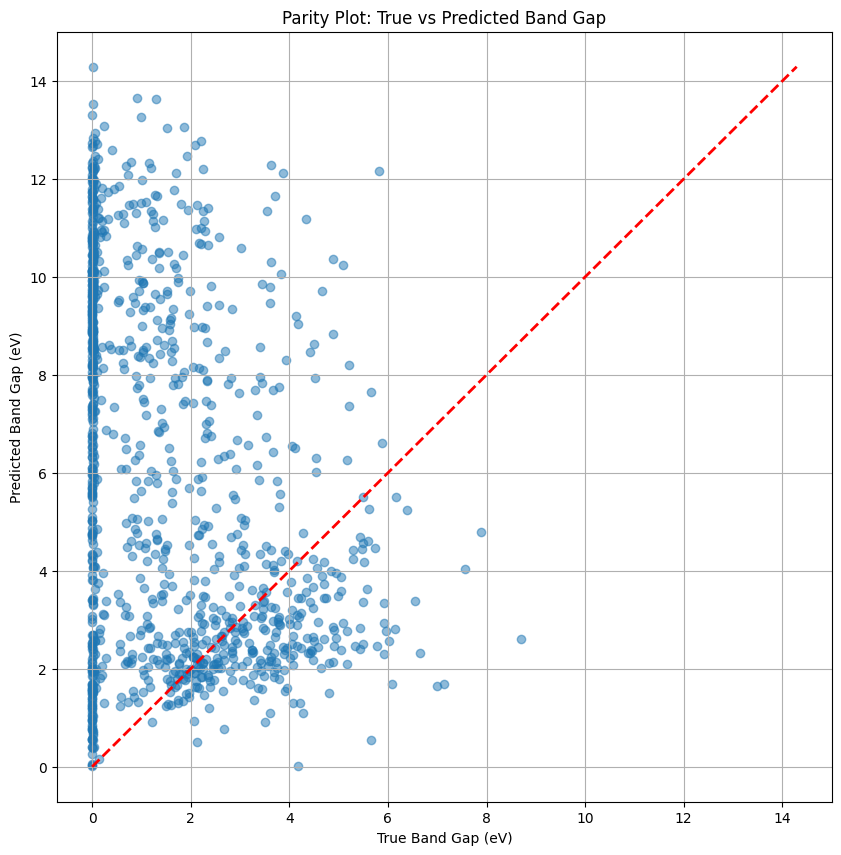

In [9]:
y_pred, y_test = evaluate_regressor_model(model_files[3], X_soap_test)


# Plotting the predictions
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
# Plot parity line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Parity Plot: True vs Predicted Band Gap")
plt.grid(True)
plt.show()

# Regressor: Random forest on SOAP data
loads and displays metrics for `random_forest_model.pkl`. This model was trained on all data. The filtered model (`filtered_random_forest_model.pkl`) was only ran on SOAP descriptors where the bandgap was greater than 0.02 eV. This filtered out approx 2000 compounds.

----------------------------------------------------------------------------------------------------
Loading Random Forest model: random_forest_model.pkl
----------------------------------------------------------------------------------------------------
Random Forest MAE: 0.5336 eV


Text(0, 0.5, 'Predicted Band Gap (eV)')

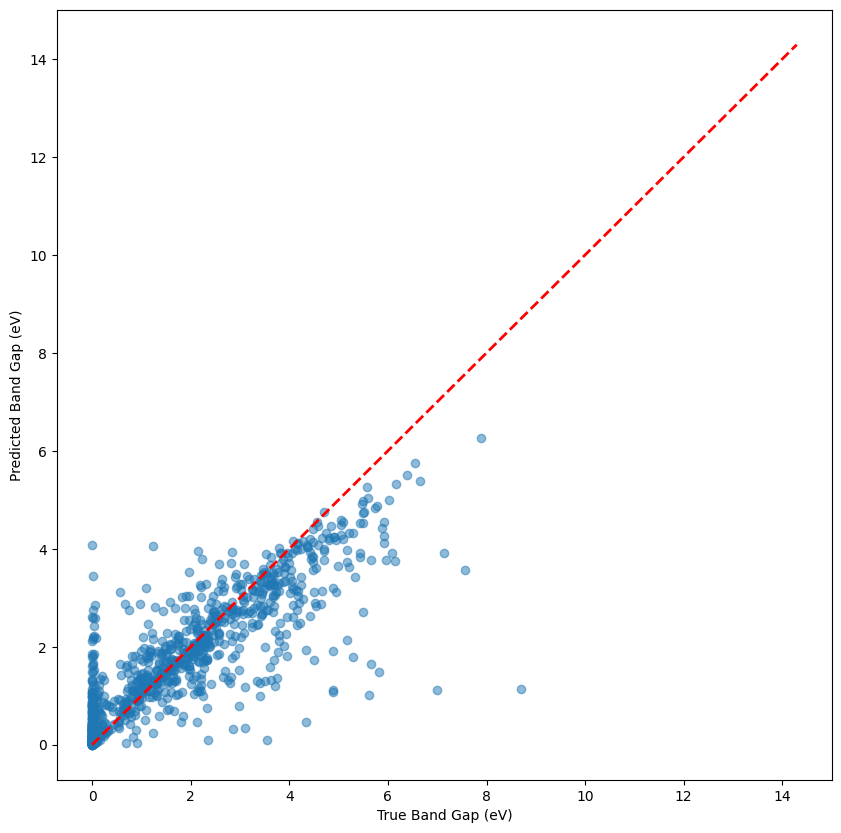

In [10]:
rf_files = ['random_forest_model.pkl', 'filtered_random_forest_model.pkl']

y_pred_rf, y_test_rf, mae_rf = evaluate_rf_model(rf_files[0], X_soap_test_flat)

plt.figure(figsize=(10, 10))
plt.scatter(y_test_rf, y_pred_rf, alpha=0.5)
# Plot parity line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")